In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import os
import sys
import pathlib
from pathlib import Path

In [2]:
# If on cluster, cwd is '/rds/general/user/nz423', not the project directory, breaking imports

# Add project directory to Python path
project_dir = Path(os.getcwd()) / "exploring-hydra-boosting"
if str(project_dir) not in sys.path:
    sys.path.append(str(project_dir))
    
class Config:
    project_dir = project_dir
    TSER_dir = project_dir / "DATASETS" / "TSER"
    BigTSC_dir = project_dir / "DATASETS" / "BigTSC"
    UTSC_dir = project_dir / "DATASETS" / "UTSC"

In [ ]:
# # Config for local machine

# project_dir = Path(os.getcwd()) / "exploring-hydra-boosting"
# class Config:
#     project_dir = project_dir
#     TSER_dir = project_dir.parent / "Data" / "TSER"
#     BigTSC_dir = project_dir.parent / "Data" / "BigTSC"
#     UTSC_dir = project_dir.parent / "Data" / "UTSC"

In [3]:
import numpy as np
import aeon
import torch
from torch import Tensor
import torch.nn as nn
import torch.functional as F
import pandas as pd
from aeon.datasets.tser_datasets import tser_soton; tser_soton = sorted(list(tser_soton))
from aeon.datasets import load_regression, load_classification
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import RidgeCV
from scipy.io import arff
from tqdm import tqdm
np.set_printoptions(precision=3, threshold=5) # Print options
from load_datasets import get_dataset_metadata_df, get_aeon_dataset
pd.set_option('display.max_rows', 130)
from aeon.datasets.tser_datasets import tser_soton; tser_soton = sorted(list(tser_soton))
from aeon.datasets.tsc_datasets import univariate_equal_length; utsc112 = sorted(list(univariate_equal_length))
big_TSC_names = [
    "Sleep",
    "MosquitoSound",
    "Tiselac",
    #"CardiacArrhythmia", #TODO download link broken
    "InsectWingbeat",
    "InsectSound",
    "FruitFlies",
    "RightWhaleCalls",
    "FaultDetectionA",
]

# Gathering some thoughts:

Potential datasets to test on: 
    Regression:
        * TSER (however, only approx 10 are 5000>n_obs)
    Classification:
        * UCR archive (112), but most n_obs<1000, and low T
        * MTSC, but most are very small
        * Bigger: MosquitoSound (139780, T 3750), InsectSound (25000, T 600), FruitFlies (17259, T 5000) etc, see list below 

Time Series Classification website https://www.timeseriesclassification.com/dataset.php

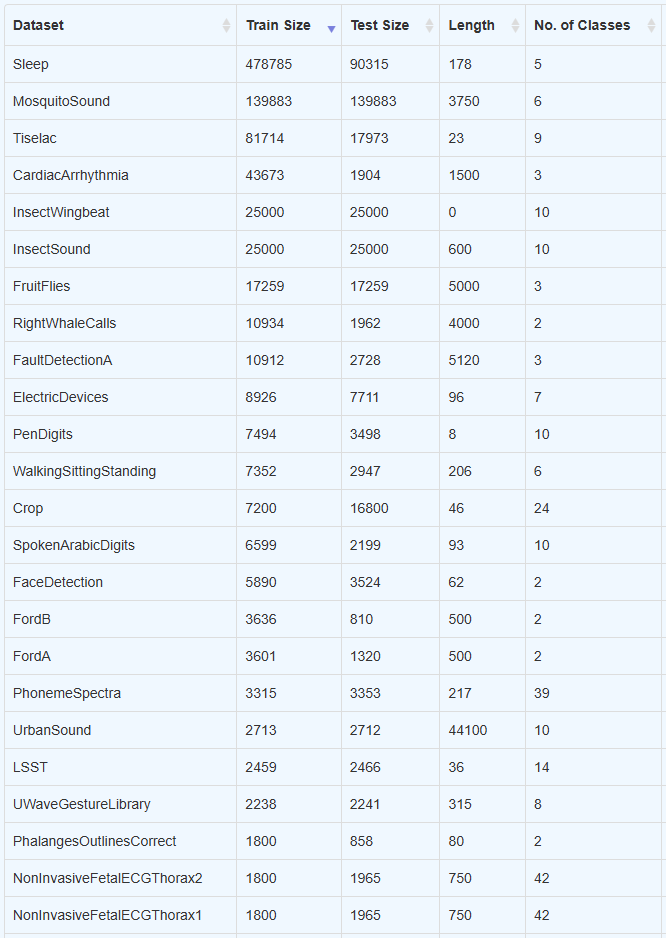

MTSR:

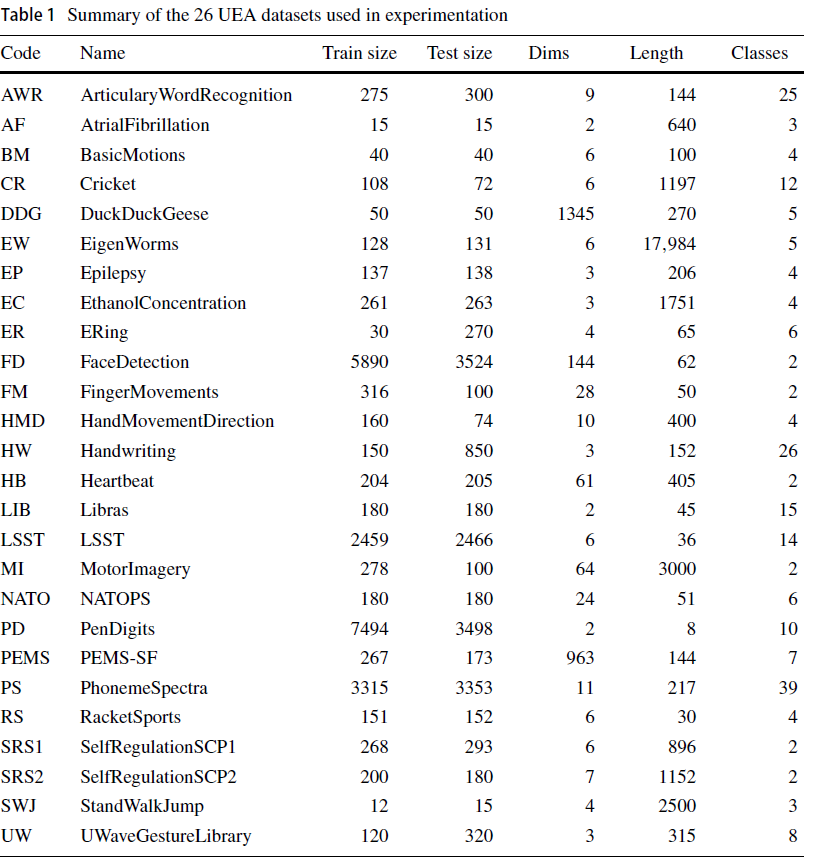

# Load metadata

Let's start with the 26 TSER

In [12]:
tser_metadata = get_dataset_metadata_df(tser_soton, Config.TSER_dir, "regression", force_refresh=False)
tser_metadata.sort_values('n_train', ascending=False)
# tser_metadata["size"] = tser_metadata["n_train"]*tser_metadata["length"]*tser_metadata["dim"]
# tser_metadata.sort_values('size', ascending=False)

,n_train,n_test,length,dim
AustraliaRainfall,112186,48081,24,3
NewsHeadlineSentiment,58213,24951,144,3
NewsTitleSentiment,58213,24951,144,3
VentilatorPressure,52815,22635,80,2
PPGDalia,43215,21482,256,4
DailyTemperatureLatitude,27440,11760,365,1
ElectricMotorTemperature,15503,6645,60,6
BeijingPM10Quality,11918,5048,24,9
BeijingPM25Quality,11918,5048,24,9
BIDMC32HR,5550,2399,4000,2


In [13]:
X_train, y_train, X_test, y_test = get_aeon_dataset("WindTurbinePower", Config.TSER_dir, "regression")
print("X_train", X_train.shape, X_train.dtype, X_train)
print("y_train", y_train.shape, y_train.dtype, y_train)
print("X_test", X_test.shape, X_test.dtype, X_test)
print("y_test", y_test.shape, y_test.dtype, y_test)

X_train (596, 1, 144) float64 [[[ 88.004  83.162  80.892 ... 100.98  100.996 101.092]]

 [[ 24.873  22.712  21.373 ...  26.899  25.969  20.351]]

 [[101.116 101.073 101.049 ...  98.825  96.719 100.736]]

 ...

 [[ 31.609  35.129  35.102 ...  16.684   9.297   7.411]]

 [[ 84.756  87.378  69.456 ... 101.022 100.98  101.104]]

 [[ 68.518  81.251  82.089 ... 100.835 100.854 100.081]]]
y_train (596,) float64 [2342.939 1006.635 2619.285 ...  715.072 2626.806 2528.095]
X_test (256, 1, 144) float64 [[[ 1.000e+05  1.000e+05  1.000e+05 ...  8.773e+01  8.689e+01  9.401e+01]]

 [[-3.189e+02 -2.960e+02 -2.403e+02 ...  1.011e+02  1.001e+02  9.688e+01]]

 [[ 2.416e+01  2.094e+01  1.439e+01 ... -2.085e+00  1.639e+01  1.872e+01]]

 ...

 [[ 2.827e+00  2.672e+00  4.193e+00 ... -5.701e+01 -5.138e+01 -5.492e+01]]

 [[ 1.365e+01  1.006e+01  8.825e+00 ...  7.007e+01  7.296e+01  8.278e+01]]

 [[ 9.787e+00  8.518e+00  1.000e+05 ... -3.828e+01 -3.980e+01 -5.080e+01]]]
y_test (256,) float64 [2156.495 1186.287  

Now do 112 UTSC

In [15]:
utsc_metadata = get_dataset_metadata_df(utsc112, Config.UTSC_dir, "classification", include_n_classes=True, force_refresh=False)
utsc_metadata.sort_values('n_train', ascending=False)

,n_train,n_test,length,dim,n_classes
ElectricDevices,8926,7711,96,1,7
Crop,7200,16800,46,1,24
FordB,3636,810,500,1,2
FordA,3601,1320,500,1,2
PhalangesOutlinesCorrect,1800,858,80,1,2
NonInvasiveFetalECGThorax2,1800,1965,750,1,42
NonInvasiveFetalECGThorax1,1800,1965,750,1,42
Wafer,1000,6164,152,1,2
StarLightCurves,1000,8236,1024,1,3
TwoPatterns,1000,4000,128,1,4


In [ ]:
X_train, y_train, X_test, y_test = get_aeon_dataset("Wafer", Config.UTSC_dir, "classification")
print("X_train", X_train.shape, X_train.dtype, X_train)
print("y_train", y_train.shape, y_train.dtype, y_train)
print("X_test", X_test.shape, X_test.dtype, X_test)
print("y_test", y_test.shape, y_test.dtype, y_test)

Finally do the big TSC problems

In [16]:
big_metadata = get_dataset_metadata_df(big_TSC_names, Config.BigTSC_dir, "classification", include_n_classes=True, force_refresh=False)
big_metadata.sort_values('n_train', ascending=False)

,n_train,n_test,length,dim,n_classes
Sleep,478785,90315,178,1,5
MosquitoSound,139780,139786,3750,1,6
Tiselac,81714,17973,23,10,9
InsectWingbeat,25000,25000,20,200,10
InsectSound,25000,25000,600,1,10
FruitFlies,17259,17259,5000,1,3
RightWhaleCalls,10934,1962,4000,1,2
FaultDetectionA,10912,2728,5120,1,3


In [ ]:
X_train, y_train, X_test, y_test = get_aeon_dataset("MosquitoSound", Config.BigTSC_dir, "classification")
print("X_train", X_train.shape, X_train.dtype, X_train)
print("y_train", y_train.shape, y_train.dtype, y_train)
print("X_test", X_test.shape, X_test.dtype, X_test)
print("y_test", y_test.shape, y_test.dtype, y_test)

In [ ]:
# HydraBoost: improving time series regression and classification with representation boosting
# HydraBoost: improving time series random features using representation boosting

# Rocket-class features

In [ ]:
# import aeon
# from aeon.transformations.collection.convolution_based import HydraTransformer, MultiRocket, MiniRocket, Rocket
# from aeon.testing.data_generation import make_example_3d_numpy
# import torch
# seed = 0
# T = 3500
# D = 1
# # X = torch.rand( (1000, D, T))
# # X = torch.cumsum(X, axis=2)
# # X[:, 1, :] += X[:, 0, :]
# # y = torch.mean(X**2, axis=(1,2)) / 2000
# X, y = make_example_3d_numpy(
#     random_state=seed,
#     n_cases=50, 
#     n_channels=D, 
#     n_timepoints=T,
#     n_labels=3,
#     regression_target=True,
#     )
# X = torch.from_numpy(X).float()
# y = torch.from_numpy(y).float()

# print("X", X.shape, X.dtype, X)
# print("y", y.shape, y.dtype, y)

In [ ]:
# from models.hydra import HydraGPU, HydraMultivariateGPU

# import torch.nn.functional as F
# import torch.nn as nn

# hydragpu = HydraMultivariateGPU(
#     T,
#     D,
#     k = 8, 
#     g = 64, 
#     seed = seed
# ) 
# feat = hydragpu(X)
# print("feat", feat.shape, feat)


In [ ]:
# from models.hydra import HydraGPU, HydraMultivariateGPU

# import torch.nn.functional as F
# import torch.nn as nn

# hydragpu = HydraGPU(
#     T,
#     k = 8, 
#     g = 64, 
#     seed = seed
# ) 
# feat = hydragpu(X)
# print("feat", feat.shape, feat)


In [ ]:
# multirock = MultiRocket(
#     random_state=seed,
#     num_kernels = 1000,
#     max_dilations_per_kernel = 32,
#     n_features_per_kernel = 4,
#     ) 
# multirock.fit(X.numpy())  
# feat = multirock.transform(X.numpy())
# print("feat", feat.shape, feat)

# Try HydraBoost Manually

In [4]:
from models.random_feature_representation_boosting import HydraBoost
from load_datasets import get_aeon_dataset
from pathlib import Path
import os
import torch
import numpy as np

X_train, y_train, X_test, y_test = get_aeon_dataset("HouseholdPowerConsumption1", Config.TSER_dir, "regression")
#X_train, y_train, X_test, y_test = get_aeon_dataset("MethaneMonitoringHomeActivity", Config.TSER_dir, "regression")
#X_train, y_train, X_test, y_test = get_aeon_dataset("CardanoSentiment", Config.TSER_dir, "regression")
#X_train, y_train, X_test, y_test = get_aeon_dataset("FloodModeling2", Config.TSER_dir, "regression")
mean_X = X_train.mean()
std_X = X_train.std()
mean_y = y_train.mean()
std_y = y_train.std()

X_train = (X_train - mean_X) / std_X
X_test = (X_test - mean_X) / std_X
y_train = (y_train - mean_y) / std_y
y_test = (y_test - mean_y) / std_y
# mean_y = 0
# std_y = 1

def numpy_to_pytorch(X_train, y_train, X_test, y_test, 
                     X_dtype = torch.float32, 
                     y_dtype=torch.float32,
                     device="cuda"):
    return (
        torch.tensor(X_train, dtype=X_dtype, device=device),
        torch.tensor(y_train, dtype=y_dtype, device=device)[:, None],
        torch.tensor(X_test, dtype=X_dtype, device=device),
        torch.tensor(y_test, dtype=y_dtype, device=device)[:, None],
    )
    
X_train, y_train, X_test, y_test = numpy_to_pytorch(X_train, y_train, X_test, y_test)
print("X_train shape", X_train.shape)

X_train shape torch.Size([745, 5, 1440])


In [31]:
# seed=0
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)

hydraboost = HydraBoost(
    n_layers=5,
    init_n_kernels=8,
    init_n_groups=64,
    n_kernels=8,
    n_groups=64,
    max_num_channels=3,
    hydra_batch_size=10000,
    l2_reg=10,
    l2_ghat=0.1,
    boost_lr=0.1,
    train_top_at = [0, 1, 2, 3, 4, 5, 10],
    ridge_solver="solve",
    # ridge_solver="LBFGS",
    # ridge_solver="AdamW",
    lr_ridge=0.0001,
    max_iter_ridge=300,
    sgd_batch_size=256,
)


hydraboost.fit(X_train, y_train)

pred_train = hydraboost(X_train)
rmse_train = torch.mean((y_train-pred_train)**2)**0.5
pred_test = hydraboost(X_test)
rmse_test = torch.mean((y_test-pred_test)**2)**0.5
print("pred_train and y_train", torch.cat([pred_train, y_train], dim=1))

rmse_naive = torch.mean((y_test-y_train.mean())**2)**0.5

print("rmse_train", rmse_train* std_y)
print("rmse_test", rmse_test* std_y)
print("rmse_naive", rmse_naive* std_y)
# rmse_train tensor(166.1263)
# rmse_test tensor(158.5803)   solve 0  10  0.1
# rmse_train tensor(6.0013)
# rmse_test tensor(136.7277)   solve 1  10  0.1   1min 6s



# rmse_train tensor(5.9885)
# rmse_test tensor(136.7117)    lbfgs 1  10  0.1  8min 25s

# rmse_train tensor(14.1691)
# rmse_test tensor(156.5790)   4min 29s adam



#smaller exp 3 8   4 8,    cpu times

# rmse_train tensor(324.9485)
# rmse_test tensor(226.7350)  solve  0  10  0.1      1.4s
# rmse_train tensor(161.4162)
# rmse_test tensor(208.4690)  solve  1  10  0.1      2.4s


# rmse_train tensor(324.9492)
# rmse_test tensor(226.7353)
# rmse_train tensor(161.4056)
# rmse_test tensor(208.4644) lbfgs, lr=1    1  10  0.1  4.6s


# rmse_train tensor(324.7893)
# rmse_test tensor(226.6159)             0  10 0.1
# rmse_train tensor(160.5096)
# rmse_test tensor(205.8372)  Adam batch=1000, lr=0.001,    1  10  0.1   5.4s    AdamW same exactly


X tensor([[  0.9948,   1.3033,   0.3238,  ..., 153.0000, 179.0000,  69.0000],
        [  2.4039,   2.2349,   1.0482,  ..., 157.0000, 248.0000, 136.0000],
        [  1.9446,   1.9478,   0.6863,  ..., 190.0000, 218.0000, 159.0000],
        ...,
        [  2.3606,   2.9278,   1.1717,  ..., 145.0000, 197.0000,  99.0000],
        [  2.8814,   2.2064,   1.2166,  ..., 181.0000, 257.0000, 160.0000],
        [  3.8468,   3.7692,   2.3550,  ..., 149.0000, 129.0000,  65.0000]],
       device='cuda:0')
W Parameter containing:
tensor([[ 2.8950e-04,  6.5709e-05,  1.4585e-04,  ..., -8.0028e-05,
          3.4569e-04,  4.7751e-04]], device='cuda:0', requires_grad=True)
b tensor([[0.0009]], device='cuda:0')
self.X_mean tensor([[-3.1490e-07,  1.8689e-07,  4.7504e-03,  ...,  3.2180e-02,
          3.0293e-02,  3.5161e-02]], device='cuda:0')
self.y_mean tensor([[3.8403e-09]], device='cuda:0')
self.y_std tensor([[1.0007]], device='cuda:0')
EXTRA tensor([[-0.0009]], device='cuda:0')
training W0
Phi0 shape tor

# TODO

* connect to jupyter on new cluster
* add gpu integration
* speed up ghat least squares, probably via lbfgs or maybe SGD
* write tsml grid search wrapper
* write tsml optuna wrapper
* write a flattened ridge baseline
* review anomaly paper